In [1]:
#2D isothermal cylindrical SS and just SMR
'''
SOME THINGS TO INVESTIGATE:
- Convert to molar basis
- CO2 CONC HIGHER THAN EXPECTED
- DIFFUSION: https://public.websites.umich.edu/~elements/course/lectures/eleven/exam4.htm 
- energy balance
'''
from scipy.integrate import solve_bvp, solve_ivp, odeint
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#reactor constants
L = 0.0609 #m
R_inner = 2.39/1000 #m
R_outer = 3.5/1000 #m
R = R_outer - R_inner

T = 622+273 #K
P = 1 #bar or atm

sccm0 = np.array([16.16, 48.48, 0, 0, 10, 5])
mols0 = sccm0/(22410 * 60)
y0 = mols0/sum(mols0)
print(y0)
Ctot = P/(8.3144598 * 10**-5 * T)

u0 = sum(sccm0) * 273 / T * P / 1 / 60 #cm^3/sec
A = np.pi * ((R_outer*100)**2-(R_inner*100)**2) #cm^2 MIGHT HAVE TO ADJUST THE AREA CALC A BIT
v0 = u0 / A / 100 #m/sec
print(v0)

Rgas = 8.314 #J / mol·K
Easmr = 165.740 #kJ/mol
Asmr = 1.68*10**8
Eawgs = 89.23 #kJ/mol
Awgs = 9.90*10**3

Ku = 1

Keqsmr = (101325/100000)**2 * np.exp(-26830/T + 30.114)
Keqwgs = np.exp(4400/T - 4.036)

[0.20291311 0.60873933 0.         0.         0.12556504 0.06278252]
0.019712035219026


In [ ]:
#Diffusion system
#CH4, H2, CO, CO2, H2, Ar
MM = [16.04, 18.01528, 28.01, 44.009, 2.016, 39.948]
VV = [24.42, 12.7, 18.9, 26.9, 7.07, 16.1] #CHANGE THE CH4 ONE TO BE MORE ACCURATE! I DONT THINK THIS IS CORRECT RN

D0 = D1 = D2 = D3 = D4 = D5 = 8*10**-7
D = [D0, D1, D2, D3, D4, D5] #list of diffusion coefficient

Dch4-h20 = 10^-3
Dch4-co =
Dch4-co2 =
Dch4-h2 =
Dch4-ar =

In [ ]:
num_z, num_x = 50, 20 # Dimensions of the 2D domain
nz, nx = num_z, num_x+2   # Number of spatial grid points with 2 imaginary nodes
dz, dx = L / (nz - 1), R / (nx - 1)  # Spatial step sizes
z = np.linspace(0, L, nz)
x = np.linspace(0, R, nx)

u_init = np.zeros((6, len(x), len(z))).flatten() #THE NUMBER OF COMPONENTS

v = np.zeros((len(x)-2, len(z)))

def pde(t,y):
    y = y.reshape((6, nx, nz)) #THE NUMBER OF COMPONENTS
    dydx2 = np.zeros_like(y)
    dydz = np.zeros_like(y)
    dydt = np.zeros_like(y)

    #CAM MAKE THIS MORE EFFICIENT WITHOUT A FOR LOOP  F[:,0] = mols0[:6]
    for i in range(len(D)):
        y[i,:,0] = y0[i] #i, x, z

    #no flux boundary condition 
    y[:,0,1:] = y[:,2,1:] #makes it so that there is no flux on top boundary (imaginary point in y)
    
    ych4 = y[0,-2,1:]
    yh2o = y[1,-2,1:]
    yco = y[2,-2,1:]
    yco2 = y[3,-2,1:]
    yh2 = y[4,-2,1:]

    ych4avg = np.sum(y[0, 1:-1, :]/(nx-2), axis = 0)

    v[:] = v0*(-2*ych4avg + 3*y0[0])/y0[0]

    rsmr = Ku*Asmr*np.exp(-Easmr*1000/Rgas/T)*(ych4*yh2o-(P**2)*yco*(yh2**3)/Keqsmr)
    rwgs = Ku*Awgs*np.exp(-Eawgs*1000/Rgas/T)*(yh2o*yco-yco2*yh2/Keqwgs)
   
    #reaction boundary conditions.
    y[0,-1,1:] = y[0,-3,1:] + 2*dx/D0 * (- rsmr)
    y[1,-1,1:] = y[1,-3,1:] + 2*dx/D1 * (- rsmr - rwgs)
    y[2,-1,1:] = y[2,-3,1:] + 2*dx/D2 * (rsmr - rwgs)
    y[3,-1,1:] = y[3,-3,1:] + 2*dx/D3 * (rwgs)
    y[4,-1,1:] = y[4,-3,1:] + 2*dx/D4 * (3*rsmr + rwgs)
    y[5,-1,1:] = y[5,-3,1:]

    dydz[:,1:-1,1:] = (y[:,1:-1,1:] - y[:,1:-1,:-1])/dz
    dydx2[:,1:-1,:] = (y[:,2:, :] - 2 * y[:,1:-1, :] + y[:,:-2, :]) / dx**2

    for i in range(len(D)):
        dydt[i, 1:-1, :] = D[i] * dydx2[i, 1:-1, :] - v * dydz[i, 1:-1, :]

    return dydt.flatten()


t_final = 10
t_span = (0, t_final)  # Time interval
t_eval = np.linspace(0, t_final, 10)  # Time evaluation points

sol = solve_ivp(pde, t_span, u_init, method='RK45', t_eval=t_eval)

sol_plot = sol.y[:, -1].reshape((6, nx, nz)) #6 is number of components
# print(sol_plot[5,1:-1,:])

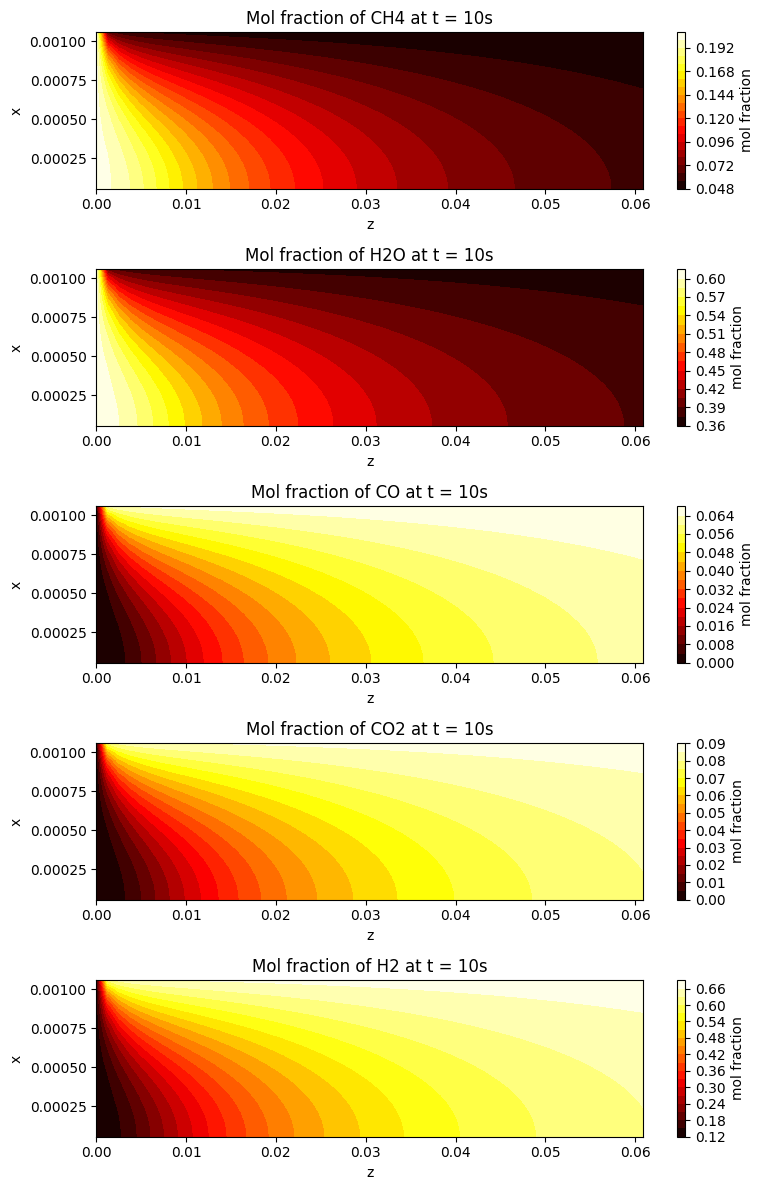

In [3]:
num_plts = 5
fig, ax = plt.subplots(num_plts, 1, figsize=(8, 12))
levels = np.linspace(0,1,100)
labels = ['CH4', 'H2O', 'CO', 'CO2', 'H2', 'Ar']
for i in range(num_plts):
    ax[i].contourf(z, x[1:-1], sol_plot[i, 1:-1, :], 20, cmap='hot')
    ax[i].set_title(f'Mol fraction of {labels[i]} at t = {sol.t[-1]:.0f}s')
    ax[i].set_xlabel('z')
    ax[i].set_ylabel('x')
    fig.colorbar(ax[i].contourf(z, x[1:-1], sol_plot[i, 1:-1, :], 20, cmap='hot'), ax=ax[i], label='mol fraction')

plt.tight_layout()
plt.show()

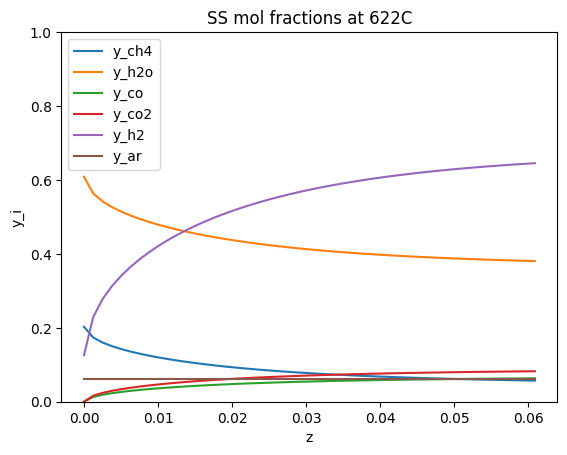

In [4]:
sol_1d = np.sum(sol_plot[:, 1:-1, :]/(nx-2), axis = 1)
# print(sol_1d)
plt.plot(z, sol_1d[0], label='y_ch4')
plt.plot(z, sol_1d[1], label='y_h2o')
plt.plot(z, sol_1d[2], label='y_co')
plt.plot(z, sol_1d[3], label='y_co2')
plt.plot(z, sol_1d[4], label='y_h2')
plt.plot(z, sol_1d[5], label='y_ar')
plt.ylim(0, 1)
plt.xlabel('z')
plt.ylabel('y_i')
plt.title('SS mol fractions at ' + str(T-273) + 'C')
plt.legend()

In [5]:
print(sol_1d[:,-1])
print(sum(sol_1d[:,-1]))

[0.05713861 0.3805329  0.06334256 0.08243193 0.64532047 0.06278252]
1.291548994405735


Text(0.5, 1.0, 'SS velocity profile')

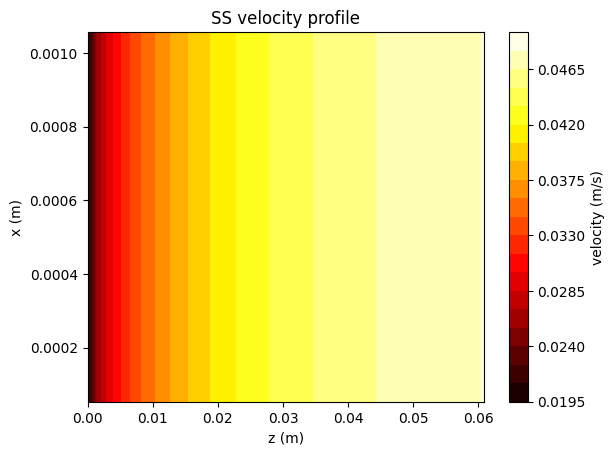

In [6]:
# print(v)
contour = plt.contourf(z, x[1:-1], v, 20, cmap='hot')
plt.colorbar(contour, label='velocity (m/s)')
plt.xlabel('z (m)')
plt.ylabel('x (m)')
plt.title('SS velocity profile')
